# [Topic Modeling](https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24)

In [148]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
# from nltk.stem.porter import *
from gensim import parsing

import numpy as np
np.random.seed(2018)
import nltk

# reload only imported modules before run
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

'''
pantree bank tags: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
standford source: https://nlp.stanford.edu/software/CRF-NER.shtml
standford online text tree generater: http://nlp.stanford.edu:8080/parser/index.jsp
'''

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'\npantree bank tags: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html\nstandford source: https://nlp.stanford.edu/software/CRF-NER.shtml\nstandford online text tree generater: http://nlp.stanford.edu:8080/parser/index.jsp\n'

### constants

In [149]:
virtual_env = 'VIRTUAL_ENV'
comments_path = 'comments_path'
emoji_path = 'emoji_path'
wordFile_path = 'wordFile_path'

start_date = '09-01-2018' #  09-Sep-2018 
end_date = '01-10-2018' # 01-Oct-2018

### We will perform the following steps:

#### 1. Tokenization: 
Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.

In [150]:
def tokenize(text):
    return gensim.utils.simple_preprocess(text)

#### 2. Remove small words:
Words that have fewer than 3 characters are removed.

In [151]:
def isShortWord(token):
    return len(token) < 3

#### 3. Remove stopwords:
All stopwords are removed.

In [152]:
def isStopWord(token):
    return token in gensim.parsing.preprocessing.STOPWORDS

#### 4. lemmatized +  Stemming:
Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.

Words are stemmed — words are reduced to their root form.

In [153]:
from nltk.corpus import wordnet as wn
from nltk import pos_tag, word_tokenize
from nltk.stem.porter import *
from textblob import TextBlob


def lemmatize_stemming(token):
    stemmer = PorterStemmer() #gensim.parsing.stem_text(tokenize) #
    for word, tag in pos_tag(word_tokenize(token)):
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        lemma = WordNetLemmatizer().lemmatize(word, wntag) if wntag else word
        return TextBlob(lemma).words[0].singularize()
    return ''

#### 5. Replace Emojis:

In [154]:
# ## get emoji characters file path
# def getEmojis():
#     from dataSource import getEmojis
#     comments_file_path = getDataSourcePathFor(emoji_path)
#     return getEmojis(comments_file_path)#.head()

In [155]:
# def hasEmojicon(token):
    
# def replaceEmojicons(token, emojies):
#     pass
    

## Data Source

In [156]:
def getNounList(sentence):
    from nltk import word_tokenize, pos_tag
    nouns = [token for token, pos in pos_tag(word_tokenize(sentence)) if pos.startswith('NN')]
    return nouns

In [157]:
# text = 'I Have done reviewing, Will be seeing by them'
# print(preprocess(text))

In [158]:
# key is file storage path
def getDataSourcePathFor(keyForFilePath):
    import json
    import os
    
    config_file_path = os.environ[virtual_env] + '/config.json'

    with open(config_file_path) as f:
        config = json.load(f)
        if keyForFilePath in config:# ['comments_path', 'output_path']
            return config[keyForFilePath] 
    return None

In [159]:
## get list of comments from stored input csv file
from dataSource import getComments, sortedMostNeg, sortedMostPos, sortedMostFreq
def getListOfComments():
    ### This is to get csv rows between given dates
    comments_file_path = getDataSourcePathFor(comments_path)
    commentsList = getComments(comments_file_path, start_date, end_date)['comments'] 
    print('Total number of comments: %s between %s and %s' % (len(commentsList), start_date, end_date))
    return commentsList

### Text processing

In [160]:
import re
def filters(sentence):
#     print('..given comments:', sentence)
    result = []
    #nouns = getNounList(sentence) # fetch only Nouns
    for token in tokenize(sentence):#nouns: ###tokenize(text):
        if not (isStopWord(token) or isShortWord(token)):
            lemmaWord = lemmatize_stemming(token)
            if not isShortWord(lemmaWord):
                result.append("".join(re.findall("[a-zA-Z]+", lemmaWord)).lower())
    return result

In [161]:
def preprocessCommentDocument(document):
    return list(map(lambda sentence: filters(sentence), document))

### Word Cloud

In [162]:
from wordCloud import showWordCloud
def showCloud(topicCollection):
    showWordCloud(topicCollection) 

### Bag of Words on the Data set

In [163]:
def bow(processed_docs):
    dictionary = gensim.corpora.Dictionary(processed_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)
    bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
    print(bow_corpus)

### Sentiment

In [164]:
from getSentiment import getSentiment

def getSentFromCommentList(commentList):
    sentimentList = []
    for sentence in commentList:
        sentiment = getSentiment(sentence)
        sentimentList.append(sentiment)
    return sentimentList


def isNegative(sentiment):
    return sentiment > 0.5


def tokenDictWithPosNegSentiment(sentimentList, document):
    sentDict = {}
    size = range(len(document))
    
    for i in size:
        for token in document[i]:
            v = (0, 0, 0) # (neg, pos, freq)
            if token in sentDict:
                v = sentDict[token]
                
            if isNegative(sentimentList[i]):
                v = (v[0]+1, v[1], v[2]+1)
            else:
                v = (v[0], v[1]+1, v[2]+1)
            sentDict[token] = v
    sentDict.pop('', None)
    return sentDict

### Main()

In [165]:
commentsDocument = getListOfComments().head(500)
processed_doc = preprocessCommentDocument(commentsDocument)
# print('..bag of words: ', bow(processed_doc))

Total number of comments: 880 between 09-01-2018 and 01-10-2018


In [166]:
sentList = getSentFromCommentList(commentsDocument)

In [167]:
from dbsWordList import DBSWordList
file_path = getDataSourcePathFor(wordFile_path)
trie = DBSWordList(file_path)

..DBSWordList constructor called


In [168]:
proc_doc_exist_words = trie.searchInDocument(processed_doc) 

In [173]:
l = tokenDictWithPosNegSentiment(sentList, proc_doc_exist_words)
# print(sortedMostPos(l))

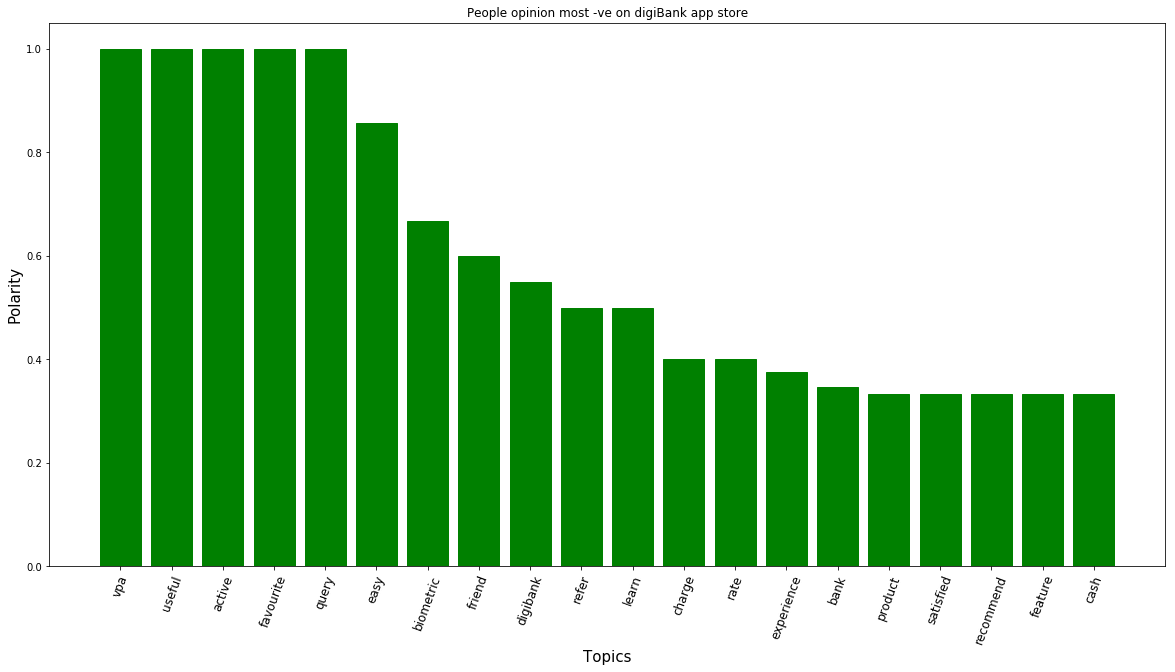

In [170]:
from showBarGraph import showBarCharForSentiment
# show positive bar graph
showBarCharForSentiment(sortedMostPos(l), pos=True)

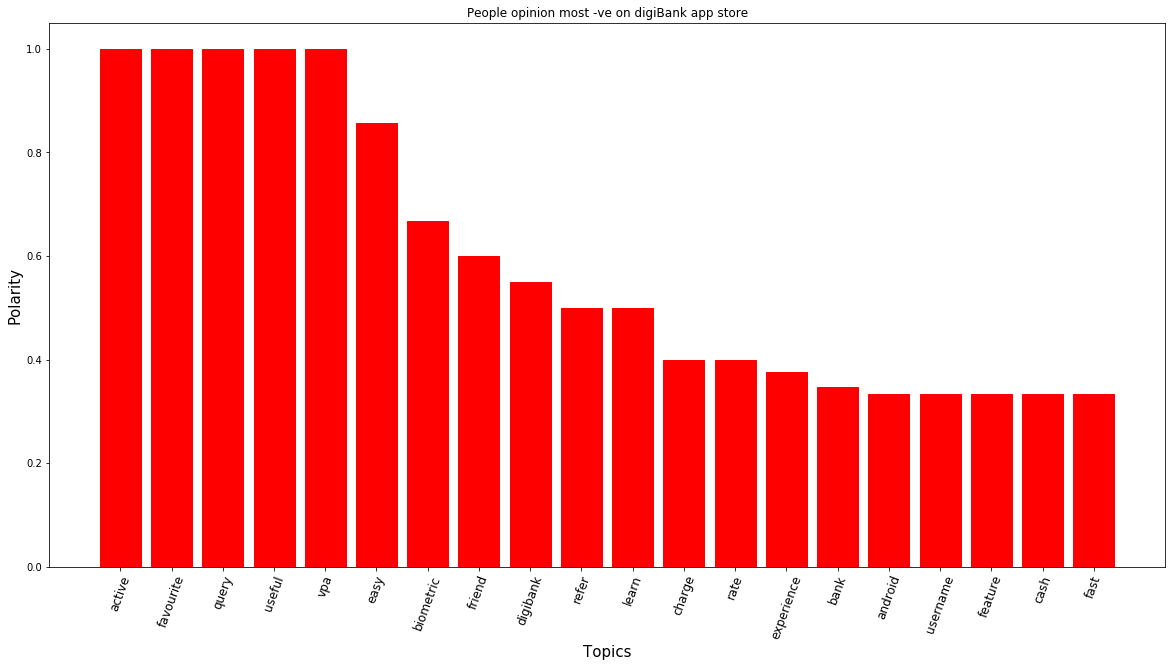

In [171]:
# show positive bar graph
showBarCharForSentiment(sortedMostNeg(l), pos=False)